<a href="https://colab.research.google.com/github/felixzhao/HARDataset/blob/main/Halter_V1_final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# packages

In [39]:
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [40]:
import plotly.express as px
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [41]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Introduction

In this report, we will discuss the pre-processing, model selection (compare with train a DNN model and a non-DNN model), and results of our recent data analysis project.
The objective of the project was to analyze a dataset and make predictions based on the information provided.

We define this work as a multi-classes classification probelm.

# Load Data & Pre-processing

set up root path, please update it to the right path.

In [42]:
root_path = "drive/MyDrive/UCI_HAR_Dataset/"

[optional] if use local path please ignore this

setup colab access to google drive

run the following code to mount the google drive in colab.

You can follow the guide, if have any question.
https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We implement two data loader classes.

1.  HARDataSetLoader

    - load Interial Signals, which will be used in DNN model training as required.
    - in this class, we pre-processed label data to transfer it to category.

2. HARFeatureLoader

    - load features data, which will be used in non-DNN model training.
    - in this class, we pre-processed features by remove duplicate features




In [44]:
"""
A python class which load Interial Signals data from HAR data set
"""
class HARDataSetLoader:
    def __init__(self, root_path):
        self.root = root_path
        self.file_dir = '/Inertial Signals/'
        self.file_prefix = ['total_acc_', 'body_acc_', 'body_gyro_']
        self.feature_type = ['x_', 'y_', 'z_']
        self.file_type = '.txt'
        self.num_classes = None

    def _get_feature_files_full_path(self, file_type:str):
        feature_files = []
        for prefix in self.file_prefix:
            for f_type in self.feature_type:
                full_path = f"{self.root}{file_type}{self.file_dir}" \
                            + f"{prefix}{f_type}{file_type}{self.file_type}"
                feature_files.append(full_path)
        return feature_files

    def _get_label_file_full_path(self, file_type:str):
        return f'{self.root}{file_type}/y_{file_type}.txt'

    def __load_file(self, file_path:str):
        return pd.read_csv(file_path, header=None, delim_whitespace=True).values

    def _load_feature(self, feature_files):
        features = np.dstack(
            [
                self.__load_file(f) for f in feature_files
            ]
        )
        return features

    def _load_label(self, label_file):
        """
        load label y from file,
        decrease 1 label number, as tensorflow categorical start from 0.
        then generate keras categorical of labels as output 
        """
        labels = self.__load_file(label_file)
        self.num_classes = len(np.unique(labels))
        labels = labels - 1
        return tf.keras.utils.to_categorical(labels)

    def _load(self, split_type:str):
        feature_file_names = self._get_feature_files_full_path(split_type)
        label_file_name = self._get_label_file_full_path(split_type)
        print(feature_file_names)
        print(label_file_name)
        X = self._load_feature(feature_file_names)
        y = self._load_label(label_file_name)
        print(X.shape, y.shape)
        return X, y

    def load_train(self):
        print('load train data.')
        return self._load('train')

    def load_test(self):
        print('load test data.')
        return self._load('test')

In [45]:
"""
A python class which load Features data from HAR data set
"""
class HARFeatureLoader:
    def __init__(self, root_path):
        self.root = root_path
        features_path = f'{root_path}/features.txt'
        self.x_train_path = f'{root_path}/train/X_train.txt'
        self.subject_train_path = f'{root_path}/train/subject_train.txt'
        self.label_dict = {
            1: 'WALKING', 
            2:'WALKING_UPSTAIRS',
            3:'WALKING_DOWNSTAIRS',
            4:'SITTING', 
            5:'STANDING',
            6:'LAYING'
            }
        self.feature_names = self._load_features_names(features_path)
        self.train_df = None
        self.test_df = None

    def _load_features_names(self, path:str):
        feature_names = []
        with open(path) as f:
            feature_names = [line.split()[1] for line in f.readlines()]
        return feature_names

    def _generate_path(self, split_type:str):
        x_path = f'{self.root}/{split_type}/X_{split_type}.txt'
        subject_path = f'{self.root}/{split_type}/subject_{split_type}.txt'
        y_path = f'{self.root}/{split_type}/y_{split_type}.txt'
        return x_path, subject_path, y_path

    def _remove_duplicate_columns(self, df):
        df_copy = df.copy()

        # find duplicate column names
        duplicate_cols = df_copy.columns.duplicated()

        # drop duplicate columns
        return df_copy.drop(df_copy.columns[duplicate_cols], axis=1)

    def _load(self, x_path, subject_path, y_path):
        x = pd.read_csv(x_path, delim_whitespace=True, header=None)
        x.columns = [self.feature_names]
        x['subject'] = pd.read_csv(subject_path, header=None, squeeze=True)
        y = pd.read_csv(y_path, names=['Activity'], squeeze=True)
        y_labels = y.map(self.label_dict)
        df = x
        df['Activity'] = y
        df['ActivityName'] = y_labels
        return df

    def _load_features(self, df):
        raw_df = self._remove_duplicate_columns(df)
        columns = raw_df.columns \
                        .get_level_values(0) \
                        .str.replace('[()]','') \
                        .str.replace('[-]', '') \
                        .str.replace('[,]','')
        raw_df.columns = columns
        x = raw_df.drop(['subject', 'Activity', 'ActivityName'], axis=1)
        y = raw_df.ActivityName
        print(f'{x.shape=}, {y.shape=}')
        return x, y


    def load_train(self):
        print('load train data.')
        x_path, subject_path, y_path = self._generate_path('train')
        self.train_df = self._load(x_path, subject_path, y_path)
        return self._load_features(self.train_df)

    def load_test(self):
        print('load test data.')
        x_path, subject_path, y_path = self._generate_path('test')
        self.train_df = self._load(x_path, subject_path, y_path)
        return self._load_features(self.train_df)

## EDA

In [90]:
eda_loader = HARFeatureLoader(root_path)
eda_loader.load_train()
eda_train_df = eda_loader.train_df
eda_train_df.head(2)

load train data.
x.shape=(7352, 435), y.shape=(7352,)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [93]:
eda_train_df.isnull().sum()

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
ActivityName            0
Length: 564, dtype: int64

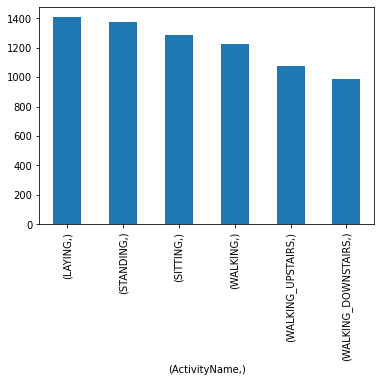

In [108]:
eda_train_df.ActivityName.value_counts().plot.bar()

# Model Selection

Once the data was pre-processed, we moved on to selecting the appropriate models for our analysis. We evaluated multiple models, including one DNN model and one non-DNN model which is CNN + LSTM and XGBoost. We chose these models because they are commonly used for regression and classification tasks and have shown to perform well on similar datasets.

## Regularization

Regularization is a technique used to prevent overfitting in deep neural networks (DNNs). Some common regularization methods include:

- L1 regularization: Also known as Lasso regularization, this method adds a penalty term to the loss function that is proportional to the absolute value of the weights. This results in some weights being set to zero, effectively removing those features from the model.

- L2 regularization: Also known as Ridge regularization, this method adds a penalty term to the loss function that is proportional to the square of the weights. This results in small, non-zero weights, which can help prevent overfitting.

- Dropout: This is a form of regularization that randomly drops out neurons during training, forcing the remaining neurons to learn more robust features.

- Early stopping: This method stops training the model before it reaches convergence, in order to prevent overfitting.

- Data augmentation: This method artificially increases the size of the training dataset by applying random transformations to the existing data, such as flipping images or adding noise. This can help the model generalize better.

- Batch normalization: This method normalizes the activations of the neurons in a batch, which helps to speed up training and reduce the effects of internal covariate shift.

- Max norm regularization: This method constrains the weights of the network such that the maximum L2 norm of the weights of a layer is less than a fixed value.

- Weight decay: This method is similar to L2 regularization, but instead of adding the penalty term to the loss function, it modifies the learning rate so that the optimizer takes smaller steps when the gradients are high.



As we known, in this problem the data is not sparse data. 

Thus, for DNN model L2 may the better way than L1, as L1 could removing features. And we will try Dropout and early stopping as well.

But for XGboosts L1 is more popular, thus we will use L1 for it.

## DNN model

Train CNN + LSTM model

Here we use an CNN + LSTM solution.

Convolutional neural networks (CNNs) are commonly used in image and video processing tasks, but they can also be applied to time series data. In particular, a 1D convolutional layer (Conv1D) can be used to extract features from a time series by sliding a kernel (a small matrix of weights) along the sequence, performing a dot product at each position, and applying a non-linear activation function. This allows the model to learn local patterns in the data, such as trends or periodicity, that may be useful for classification. Additionally, Conv1D can also be used in combination with pooling layers to reduce the dimensionality of the data and make the model more robust to noise.

In [46]:
loader = HARDataSetLoader(root_path=root_path)
X_train, y_train = loader.load_train()
X_test, y_test = loader.load_test()
print(f'{loader.num_classes=}')

load train data.
['drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_z_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_z_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_z_train.txt']
drive/MyDrive/UCI_HAR_Dataset/train/y_train.txt
(7352, 128, 9) (7352, 6)
load test data.
['drive/MyDrive/UCI_HAR_Dataset/test/Inertial Signals/total_acc_x_test.txt', 'drive/MyDrive/UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt', 'drive/MyDrive/UCI_HAR_Dataset/test/Inert

In [47]:
train_shape = X_train.shape
batch_size = train_shape[0]
sequence_length = train_shape[1]
number_of_features = train_shape[2]
num_classes = loader.num_classes
print(f"{batch_size=}, {sequence_length=}, {number_of_features=}, {num_classes=} ")

batch_size=7352, sequence_length=128, number_of_features=9, num_classes=6 


In [48]:
learning_rate = 0.01
n_hidden = 32
batch_size = 64
shuffle_buffer_size = 1000
epochs = 30

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that can be used for time series classification tasks. Unlike traditional RNNs, LSTMs have a memory cell that can store information from previous time steps, allowing them to better handle long-term dependencies in the data. This is especially useful for time series data, where patterns may be spread out over a long period of time and traditional RNNs may struggle to capture these dependencies. Additionally, LSTMs have gates (input, output and forget gates) that can selectively choose which information to keep, discard or update in the memory, which helps to prevent the vanishing and exploding gradient problem commonly faced by RNNs. LSTM can learn to recognize patterns, trends and anomalies in sequential data, which is useful in time series classification tasks.

Softmax is a common choice for the final activation function in a neural network when the task is multi-class classification. The function maps the output of the network to a probability distribution over the different classes, allowing the model to make predictions about the most likely class for a given input.






In [49]:
"""
padding='causal', 
    the input tensor is only padded on the left side, 
    and the output at time t only depends on past observations 
    and not on future observations. 
    This is useful in time series analysis.

strides=1, 
    the filter moves one step at a time along the width dimension, 
    and the output will have the same width as the input. 
    This means that the filter will be applied to every element of the input tensor, 
    resulting in the most detailed representation of the input. 

kernel_regularizer=tf.keras.regularizers.l2(0.001),
    the L2 regularizer is being used with a regularization rate of 0.001. 
    This means that for every weight in the weight matrix, 
    the square of its value will be multiplied by 0.001 
    and added to the overall loss during training, 
    encouraging the weights to be small and reducing overfitting.
"""
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
      filters=32, 
      kernel_size=4,
      strides=1,
      activation="relu",
      padding='causal',
      input_shape=(sequence_length, number_of_features),
      kernel_regularizer=tf.keras.regularizers.l2(0.001),
      ),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

#Print the model summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 128, 32)           1184      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 12,006
Trainable params: 12,006
Non-trainable params: 0
_________________________________________________________________


In [50]:
# early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
early_stop_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-8, verbose=1)


# Train the model
history = model.fit(X_train, y_train ,validation_data=(X_test, y_test) ,epochs=50, callbacks=[early_stop_acc, reduce_lr])

Epoch 1/50
230/230 [==============================] - 15s 58ms/step - loss: 0.7602 - accuracy: 0.6601 - val_loss: 0.7610 - val_accuracy: 0.6770 - lr: 0.0100
Epoch 2/50
230/230 [==============================] - 13s 55ms/step - loss: 0.4930 - accuracy: 0.8417 - val_loss: 0.5503 - val_accuracy: 0.8293 - lr: 0.0100
Epoch 3/50
230/230 [==============================] - 13s 56ms/step - loss: 0.3040 - accuracy: 0.9212 - val_loss: 0.6977 - val_accuracy: 0.7445 - lr: 0.0100
Epoch 4/50
230/230 [==============================] - 13s 56ms/step - loss: 0.2950 - accuracy: 0.9166 - val_loss: 0.4724 - val_accuracy: 0.8588 - lr: 0.0100
Epoch 5/50
230/230 [==============================] - 14s 63ms/step - loss: 0.2673 - accuracy: 0.9245 - val_loss: 0.4803 - val_accuracy: 0.8928 - lr: 0.0100
Epoch 6/50
230/230 [==============================] - 13s 56ms/step - loss: 0.3602 - accuracy: 0.8984 - val_loss: 0.5920 - val_accuracy: 0.8653 - lr: 0.0100
Epoch 7/50
230/230 [==============================] - 13s 

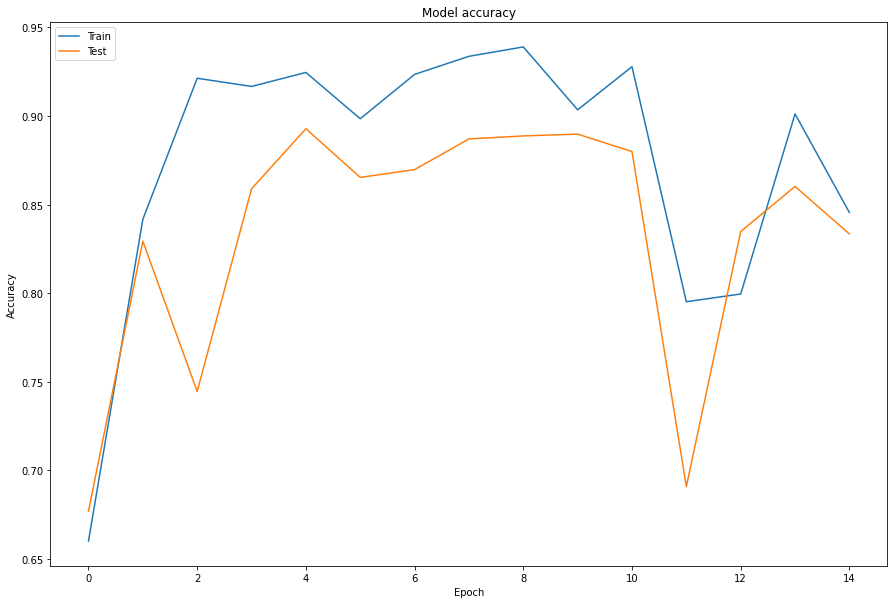

In [51]:
fig = plt.figure(figsize=(15, 10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Non-DNN model

XGBoosts model training

XGBoost is a powerful and widely-used library for gradient boosting, which is a technique for building ensemble models by iteratively training weak models and combining them to form a stronger model. XGBoost is particularly useful in multi-class classification problems because it can handle large datasets, missing data, and categorical variables, and it has many built-in features to improve model performance, such as regularization and feature selection.



In [55]:
loader_2 = HARFeatureLoader(root_path)
X_train_2, y_train_2 = loader_2.load_train()
X_val_2, y_val_2 = loader_2.load_test()

load train data.
x.shape=(7352, 435), y.shape=(7352,)
load test data.
x.shape=(2947, 435), y.shape=(2947,)


In [56]:
labels_2=list(loader_2.label_dict.values())

In [58]:


# Create the XGBoost model
model_2 = xgb.XGBClassifier(reg_lambda=0.1)

# Fit the model to the training data
eval_set = [(X_train_2, y_train_2), (X_val_2, y_val_2)]
model_2.fit(X_train_2, y_train_2, eval_set=eval_set, eval_metric="merror", early_stopping_rounds=5)

# Make predictions on the training and validation sets
train_predictions = model_2.predict(X_train_2)
val_predictions = model_2.predict(X_val_2)

# Evaluate the model's accuracy on the training and validation sets
train_accuracy = accuracy_score(y_train_2, train_predictions)
val_accuracy = accuracy_score(y_val_2, val_predictions)

[0]	validation_0-merror:0.07685	validation_1-merror:0.183916
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.068689	validation_1-merror:0.144554
[2]	validation_0-merror:0.065016	validation_1-merror:0.143196
[3]	validation_0-merror:0.063248	validation_1-merror:0.139803
[4]	validation_0-merror:0.060664	validation_1-merror:0.138785
[5]	validation_0-merror:0.058487	validation_1-merror:0.135731
[6]	validation_0-merror:0.053455	validation_1-merror:0.128266
[7]	validation_0-merror:0.052775	validation_1-merror:0.125212
[8]	validation_0-merror:0.049374	validation_1-merror:0.118765
[9]	validation_0-merror:0.047062	validation_1-merror:0.114014
[10]	validation_0-merror:0.045838	validation_1-merror:0.111639
[11]	validation_0-merror:0.044886	validation_1-merror:0.109603
[12]	validation_0-merror:0.045294	validation_1-merror:0.109264
[13]	validation_0-merror:0.044

In [59]:
print(f'{val_accuracy=}')

val_accuracy=0.9412962334577536


In [60]:
# Create a list of the number of rounds
rounds = list(range(1, len(model_2.evals_result()['validation_0']['merror'])+1))

# Create a list of the training and validation set accuracy
train_performance = [1-x for x in model_2.evals_result()['validation_0']['merror']]
val_performance = [1-x for x in model_2.evals_result()['validation_1']['merror']]

Plotting the training and validation set performance

Check for overfitting is to plot the performance of the model on the training set and validation set over time (i.e. as the number of rounds increases). If the performance on the training set continues to improve while the performance on the validation set plateaus or decreases, it suggests that the model is overfitting.

in the following plot, it no show that.

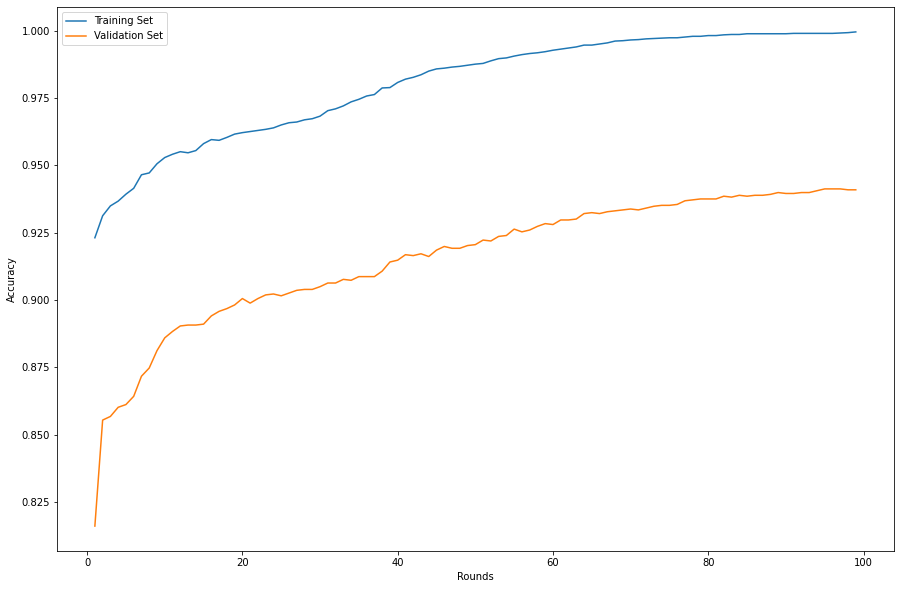

In [61]:
# Plot the training and validation set performance over time
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(rounds, train_performance, label="Training Set")
plt.plot(rounds, val_performance, label="Validation Set")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.ax = ax
plt.legend()

### Feature Importance



XGBoots provide function to plot feature importance and it can help to identify which features are the most important for the model. If a feature has a high importance, it means that it contributes more to the model's predictions. If the feature importance of some features is too high, it may indicate overfitting because the model is too dependent on them.

based on the plot result, we can not say any feature has significant larger than others

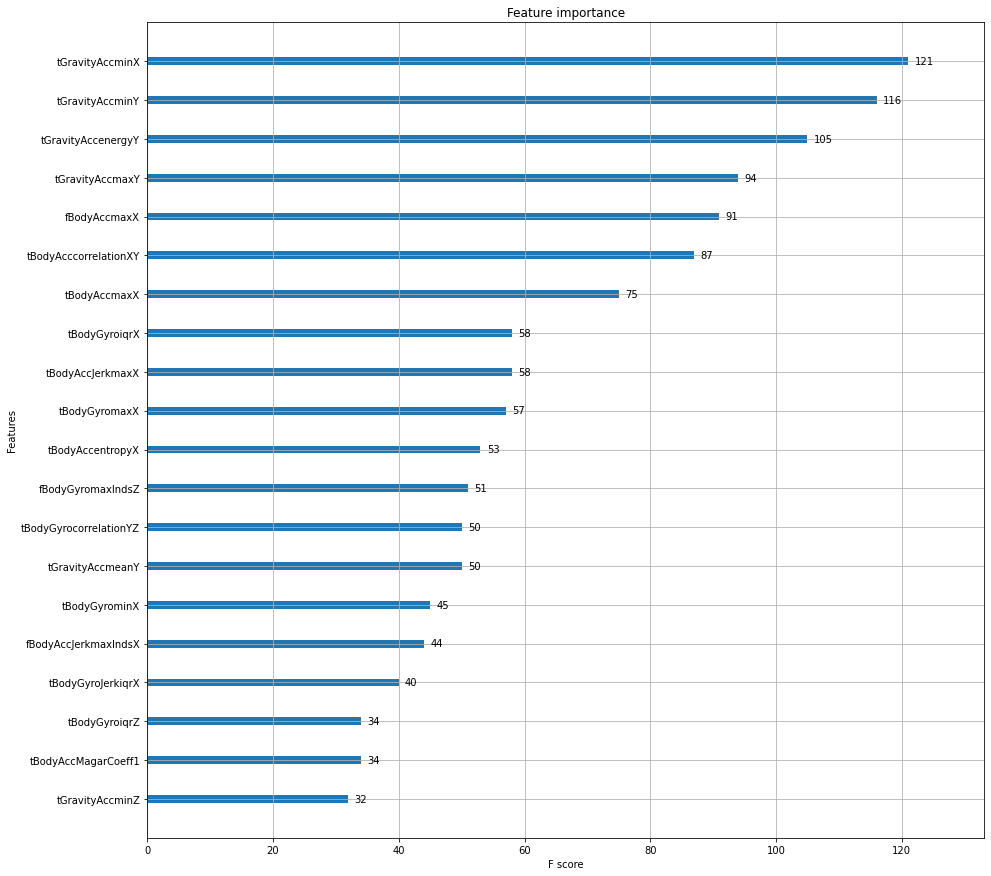

In [62]:
fig, ax = plt.subplots(figsize=(15,15))
xgb.plot_importance(model_2, ax=ax, max_num_features=20)

# Model Comparison

## DNN model - CNN + LSTM

CNN



Pros
- They are able to learn features from the input data automatically, without the need for manual feature engineering.

Cons
- CNNs require a large amount of data and computational resources to train.
- They are sensitive to the quality and annotation of the training data, which can lead to overfitting if the data is not diverse or representative enough.
- They can be difficult to interpret, as the learned features are often abstract and not directly related to the input data.

LSTM


Pros

- LSTMs are well suited for time series classification tasks as they are able to effectively capture long-term dependencies in sequential data.
- LSTMs are able to handle input sequences of varying lengths, which is useful for handling variable-length time series data.
- LSTMs are able to learn the underlying patterns and trends in the time series data, which can be useful for making accurate predictions.


Cons

- LSTMs can be computationally expensive to train and run, particularly when dealing with large input sequences or large amounts of data.
- LSTMs can be difficult to interpret and understand, as they are a complex model with many internal components.
- LSTMs can be prone to overfitting if not properly regularized, as they have a large number of parameters that can be adjusted.
- LSTMs may not be suitable for time series data with high frequency, as the model might not be able to capture the high-frequency patterns.
- LSTMs may not be suitable for time series data with a high degree of noise, as the model might not be able to differentiate between noise and signal.

## Non-DNN

XGBoosts

Pros:






- XGBoost is a highly efficient and scalable algorithm that can handle large datasets with millions of examples and features.
It can handle missing values and categorical variables, which can be transformed into numerical values using one-hot encoding.
- XGBoost uses a technique called "boosting" which combines the predictions of multiple weak models to produce a strong final prediction. This makes the model robust to overfitting and improves its generalization performance.
- XGBoost provides several regularization options such as L1 and L2 regularization which can help prevent overfitting.
It has built-in support for parallel processing which can speed up the training process.
- XGBoost has a built-in feature importance analysis mechanism, which allows you to understand which features are most important in determining the output of the model.
- XGBoost can handle imbalanced datasets where some classes have much fewer examples than others

Cons:



- XGBoost requires careful tuning of its many hyperparameters, such as the learning rate, number of trees, and regularization parameters. This can be time-consuming and requires a good understanding of the algorithm.
- XGBoost can be sensitive to the initial conditions of the data, and in some cases, it may not converge or produce poor results if the data is not properly preprocessed.
- It can be memory-intensive and may require a powerful machine to handle large datasets.
- The interpretability of the model can be difficult as it's a complex ensemble of decision trees.
- It may take longer time to train a model than other algorithms such as Random Forest or Logistic Regression.

# Results

## Results of DNN model

In the work CNN + LSTM, test accuracy reach to 91.2%.

Based on the Confusion matrix most of the classes are correct.

Except "Standing" and "sitting", which we can do more analysis in future work.

In [63]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

93/93 - 1s - loss: 0.4803 - accuracy: 0.8928 - 1s/epoch - 13ms/step
Test accuracy: 0.8927723169326782


In [64]:
y_pred = model.predict(X_test)

93/93 [==============================] - 2s 14ms/step


In [65]:
y_pred_res = tf.argmax(y_pred, axis=1)
y_test_res = tf.argmax(y_test, axis=1)

In [66]:
cm = tf.math.confusion_matrix(y_test_res, y_pred_res, num_classes=num_classes)

In [67]:
class_names = [ 'WALKING',
    'WALKING_UPSTAIRS',
     'WALKING_DOWNSTAIRS',
     'SITTING',
     'STANDING',
     'LAYING',
]

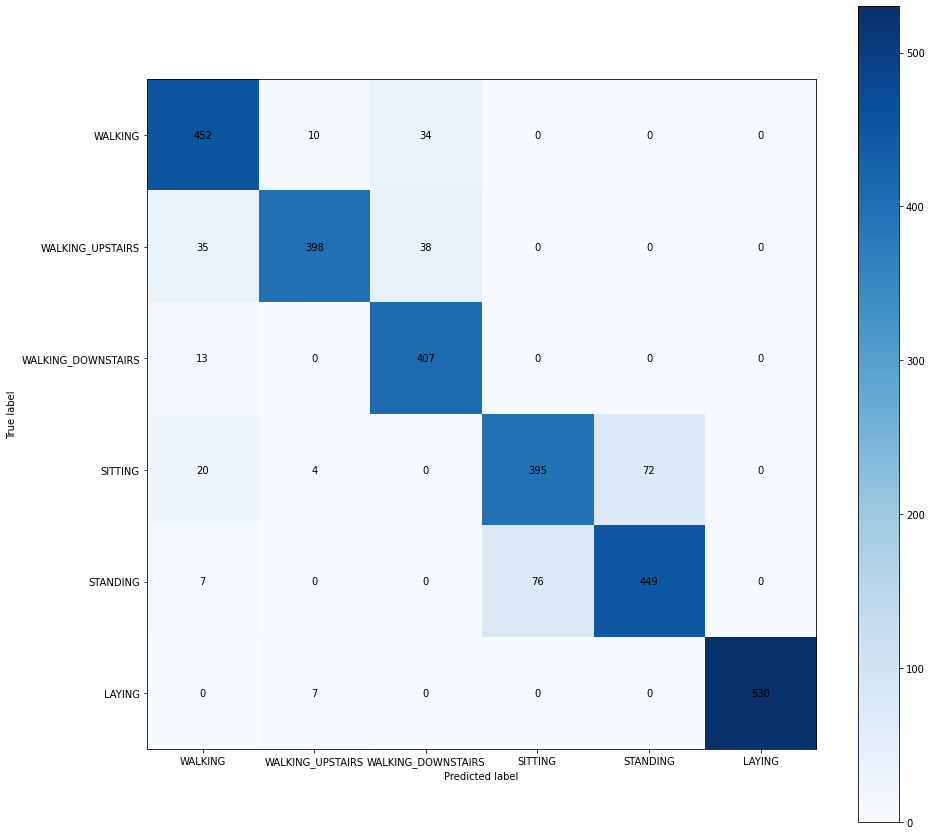

In [68]:
cm = np.array(cm)

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

## Results of XGboosts model

In the work XGBoosts, given us 94.13% acccuracy in test set.

Based on the Confusion matrix most of the classes are correct.

Except "Standing" and "sitting", which we can do more analysis in future work.

In [71]:
y_pred = model_2.predict(X_val_2)
accuracy = metrics.accuracy_score(y_true=y_val_2, y_pred=y_pred)
print(accuracy)

0.9412962334577536


Text(113.09375, 0.5, 'True')

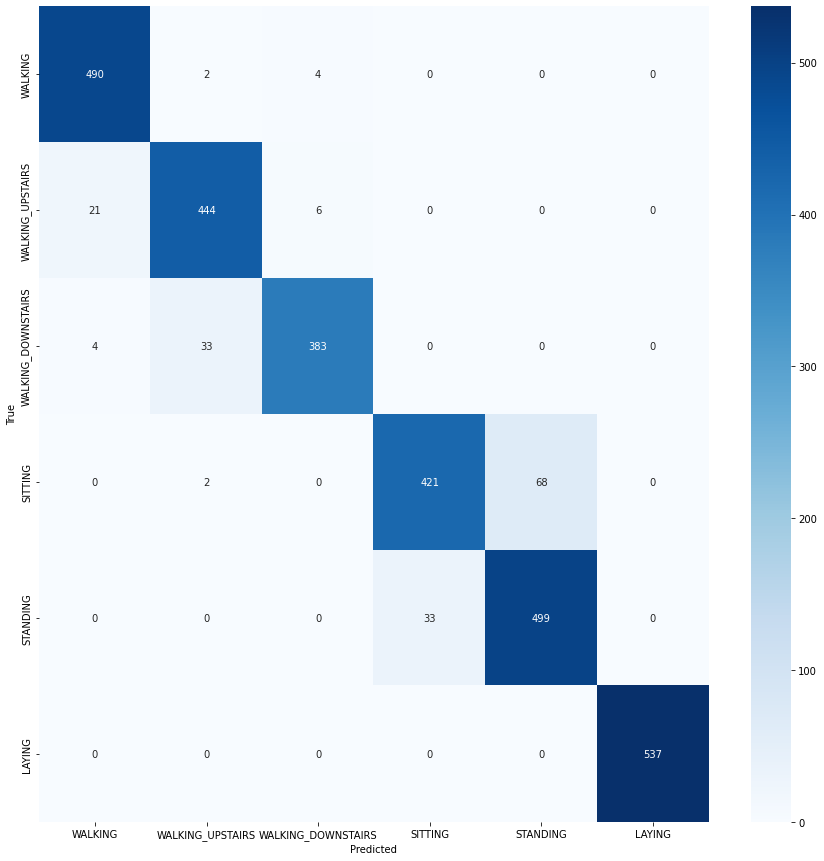

In [70]:
fig, ax = plt.subplots(figsize=(15,15))
# make predictions on the test set
y_pred = model_2.predict(X_val_2)

# create the confusion matrix
cm = confusion_matrix(y_val_2, y_pred, labels=labels_2)

# plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_2, yticklabels=labels_2)
plt.xlabel('Predicted')
plt.ylabel('True')

# Conclusion

In this work, we found DNN model is much easier overfitting than non-DNN model in this problem.

In conclusion, we pre-processed the data by cleaning and formatting it. 

We then evaluated multiple models and found that XGBoost performed the best with an accuracy of 94%. It better than DNN model 91% accuracy. 

The feature importance of top 20 features were also identified. Overall, this analysis provides valuable insights that can be used to make predictions and inform decision-making.

# Additional

GridSearchCV is a scikit-learn function that can be used to perform an exhaustive search over a specified parameter grid for an estimator. It is used to find the best combination of hyperparameters for a model, by training the model on the training data using different combinations of hyperparameters, and evaluating the performance of each combination on the validation data.

In time series multi-class classification, GridSearchCV can be used to find the optimal parameters for the model such as the window size, stride size, and other hyperparameters that are specific to the model being used for classification. By using GridSearchCV, we can tune the model's hyperparameters to achieve the best performance on the validation data, which can improve the model's performance when applied to new, unseen data.

## GSV for DNN

We can use Grid Search CV to tuning the parameters of model. for example, tunning the regulariztion rate or dropout rate.


It takes too long to run thus here is the sample code, 

In [72]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime

In [77]:
def create_model(l2_rate=0.0):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=(sequence_length, number_of_features)),
      tf.keras.layers.LSTM(32),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_rate)),
      tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )
    return model

# create the model
model_cv = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

In [78]:
# define the grid search parameters
l2_rate = [0.0, 0.001, 0.01, 0.1]
param_grid = dict(l2_rate=l2_rate)
grid = GridSearchCV(estimator=model_cv, param_grid=param_grid, cv=3)

In [79]:
start_time = datetime.now()

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(f'time cost: {datetime.now()-start_time}')

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## GSV for XGBoosts

Regularization and tuning by GridSearchCV

We can use Grid Search CV to tuning the parameters of model. for example, tunning the regulariztion rate.

It takes too long to run thus here is the sample code,

In [81]:
model = xgb.XGBClassifier(reg_lambda=0.1, early_stopping_rounds=10, eval_set=[(X_val_2, y_val_2)])

In [82]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'reg_lambda':[0.01, 0.001]}#[0, 0.001, 0.01, 0.1, 1, 10, 100]}
clf = RandomizedSearchCV(model, param_grid, cv=5)

In [ ]:
# Fit the model to the training data
clf.fit(X_train_2, y_train_2, eval_metric="merror")

In [ ]:
# Make predictions on the training and validation sets
train_predictions = clf.predict(X_train_2)

In [ ]:

val_predictions = clf.predict(X_val_2)

In [ ]:
# Evaluate the model's accuracy on the training and validation sets
train_accuracy = accuracy_score(y_train_2, train_predictions)
val_accuracy = accuracy_score(y_val_2, val_predictions)

In [ ]:
print(f'{train_accuracy=}, {val_accuracy=}')